# Generating seismic profile from a picture, convolution
[Ryan A. Mardani](https://www.linkedin.com/in/amardani/)

In subsurface imaging technology (seismic approach), we mainly try to create a profile (image/cube) from Earth's layers below the survey area to understand structural configuration. In my [previous project](https://github.com/mardani72/Synthetic_Seismogram/blob/master/Synthetic_Seismogram.ipynb), I generated synthetic seismogram (convolution of reflectivity and wavelet) which help us to tie seismic data to well data.
In this work, I am trying to exercise convolution again but without well data. I have an image of the outcrop which I took several years ago and I want to convert it to the seismic profile. Every colorful image file can be stored as a 3-dimensional array: the first and second s belong to the coordinate of a pixel(row and column) while the third one related to RGB color code.<br>
Converting a colorful image into grayscale, I assume that each column of image data is zero offset reflectivity series stored in that column. I have slightly changed the sharpness and brightness of the picture to have more distinctive reading into the array dataset. Some steps are required to get the job done:<br>

1) Reading image of png format into a vraiable<br>
2) Image Processing (converting blue color of sky into white)<br>
3) Quality Contorl and reading into grayscale format<br>
4) Statistical analysis to get rid of abnoraml spiked values<br>
5) Inverting image color scale (balck to white and vice versa)<br>
6) Sacling into a range of (-1,1), simulating reflectivity series<br>
7) Time vector initation and wavelet definition(Ricker)<br>
8) Convolving each column of picture array with wavelet<br>
9) Adding offset to each column<br> 
10) Plotting<br>


Clearly, all units are the assumption and can not be taken for quantitative analysis.

### 1) Reading image

In [1]:
import numpy as np
import cv2

In [11]:
img_col = cv2.imread('img_outcrop.png')

### 2) Image Processing

In [13]:
#converting blue color to white
m= img_col
h,w,bpp = np.shape(m)
for py in range(0,h):
    for px in range(0,w):
        if(m[py][px][0] >225):  # blue color range in RGB          
            m[py][px][0]=255    # white
            m[py][px][1]=255
            m[py][px][2]=255

cv2.imwrite('img_blue_less.png',m)    # writing image to visual quality cotrol

True

#### 3) Quality Contorl and reading into grayscale format

After changing the blue color to white, it is better to look at the result to find out if a strong alteration in the picture has happened. In this picture, it seems OK but if we have an image that blue is not as strong as sky color, we should cautiously deal with this step.

In [14]:
# Reading image as grayscale after quality control
img = cv2.imread('img_blue_less.png',0)

In [15]:
img.shape

(500, 1000)

#### 4) Statistical analysis

As this is a grayscale picture, it must be 2D array. It is better to see some statistics.

In [16]:
print('Number of dimension is:',img.ndim)
print('The minimum value is:',img.min())
print('The maximum value is:',img.max())
print(f'The standard deviation value is: {img.std():.2f}')
print(f'The mean value is: {img.mean():.2f}')

Number of dimension is: 2
The minimum value is: 0
The maximum value is: 255
The standard deviation value is: 59.12
The mean value is: 180.60


Looking at the std and mean reveals that minimum value is far from center and possibly it is a spike in some data points. Let's look at the coordinate of min values and simply plot.


In [17]:
# Using argmin we may locate the min location 
spike = np.unravel_index(img.argmin(), img.shape)
spike

(184, 818)

##### Ploting to see spikes

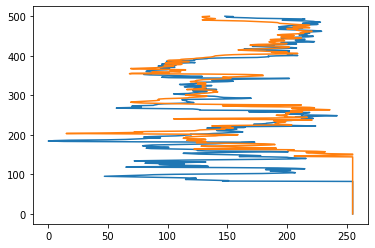

In [21]:
import matplotlib.pyplot as plt
y=np.linspace(0, img.shape[0], img.shape[0])  # vector size for ploting
plt.plot(img[:, 818], y)
plt.plot(img[:,200], y )

The plot showes normal ranges between 50 to 255. Lets remove the spikes but before that we can calculate how many data point we will modeify

In [22]:
too_dark= img < 50 
too_dark.sum()

3197

Comparing size of image matrix (>500,000), 3000 value aletartion can not make strong difference

In [23]:
img[too_dark]=50

#### 5) Inverting image color scale

we do this becuase we want to be in agreemnet with normal polarization of wavelet. Dark color in picture has smaller values than bright one and we want to change it to be adaptable with colvulution with wavelet.

In [24]:
img_inv=abs(255-img)

#### 6) Sacling into a range of (-1,1)

To make it similar to reflectivity series we can normalize data between -1 and 1. Let's use sklearn library to make it easier.

In [26]:
from sklearn.preprocessing import MinMaxScaler

In [27]:
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(img_inv)
Z1 = scaler.transform(img_inv)
Z = np.where(Z1== -1., 0, Z1 ) # converting blue to zero which in scaling process had taken extreme value -1

#### 7) Time vector initation and wavelet definition(Ricker)

In [28]:
t = np.arange(0,len(Z))/1000           # divided by 1000 to make smilar to seconds

##### Wavelet  

You may look as the full explanation of this wavelet [here](https://subsurfwiki.org/wiki/Ricker_wavelet).

In [29]:
def ricker(f, length, dt):
    t0 = np.arange(-length/2, (length-dt)/2, dt)
    y = (1.0 - 2.0*(np.pi**2)*(f**2)*(t0**2)) * np.exp(-(np.pi**2)*(f**2)*(t0**2))
    return t0, y

In [30]:
f=75            #wavelet frequency
length=0.400    #Wavelet vector length
dt=t[1]-t[0]           # Sampling prefer to use smiliar to resampled AI

In [31]:
t0, w = ricker (f, length, dt) # ricker wavelet 

#### 8) Convolution over each column (looks like receiver place)

In [32]:
syn = np.zeros((Z.shape[0], Z.shape[1]) )
for i in range(0, Z.shape[1]):
    syn[:, i] = np.convolve(w, Z[: , i], mode='same')

Plotting all columns as a synthetic trace, will strongly ocupy RAM memory and slows down the computer speed.  We can plot every 5 column to handle performance. 

In [33]:
syn1 = syn[:, 0:1000:5]

#### 9) Adding offset

Up to now, all columns are located at the same location. We need to add some regular value to make offset for ploting.

In [34]:
offsets = np.linspace(1, 200, 200 )
syn_off1 = offsets+syn1

### 10) Ploting

Plotting 200 traces still takes some struggle from a  PC. To improve the result, I switched off inline showing the result on the screen. We can look at the result as a saved figure file.

In [35]:
import matplotlib as mpl
backend_ =  mpl.get_backend() 
mpl.use("Agg")  # Prevent showing stuff


fig, ax = plt.subplots(figsize = (16,8))

for i in range(syn_off1.shape[1]):
      
    ax.plot(syn_off1,t,'k-', linewidth=0.3)
    ax.fill_betweenx(t, offsets[i] , syn_off1[:,i], where= (syn_off1[:,i]> offsets[i]),color='k', alpha=0.9)
#     ax.fill_betweenx(t, offsets[i] , syn_off1[:,i], where= (syn_off1[:,i]> offsets[i]),color='b', alpha=0.5)
#     ax.fill_betweenx(t, offsets[i] , syn_off1[:,i], where= (syn_off1[:,i]< offsets[i]),color='r', alpha=0.3)
    
ax.set_title(' Synthetic Seismic Profile from Image Convolution', fontsize = '16')
ax.set_xlabel( 'Offset(m)', fontsize = '12')
ax.set_ylabel( 'Time(S)', fontsize = '12')
ax.invert_yaxis()
plt.savefig('Syn_Out_Crop.png', dpi=300)
mpl.use(backend_) # Reset backend